# Neighborhood analysis 

In [85]:
import pickle
import sys, os
sys.path.append("/Users/chilpert/Dev/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Dev/pyproteins/src")
import pyproteinsExt 
import pyproteins
import time
import subprocess
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pyproteinsExt.uniprot as uniprot
import pyproteinsExt.ena as ena
import seaborn as sns
from collections import OrderedDict
from igraph import Graph, plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    print(saveDir + "/" + fileName)
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

### Load data

In [3]:
data=load("NOX_annotation_validatedProteins_20190808-155906.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_validatedProteins_20190808-155906.pickle
restore a annotated container of  769 elements


### Get uniprot entries

In [4]:
uColl=uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot")
c = 1
for e in data:
    if c % 10 == 0: 
        print(c,"/",len(data))
    e.set_uniprot_xref(uColl)
    c += 1
#uColl.serialize(ext=".xml")

Acknowledged 0 entries (/Users/chilpert)
Changing cache location to /Users/chilpert/cache/uniprot
Reindexing /Users/chilpert/cache/uniprot
Acknowledged 869 entries (/Users/chilpert/cache/uniprot)
10 / 769
20 / 769
30 / 769
40 / 769
50 / 769
60 / 769
70 / 769
80 / 769
90 / 769
100 / 769
110 / 769
120 / 769
130 / 769
140 / 769
150 / 769
160 / 769
170 / 769
180 / 769
190 / 769
200 / 769
210 / 769
220 / 769
230 / 769
240 / 769
250 / 769
260 / 769
270 / 769
280 / 769
290 / 769
300 / 769
310 / 769
320 / 769
330 / 769
340 / 769
350 / 769
360 / 769
370 / 769
380 / 769
390 / 769
400 / 769
410 / 769
420 / 769
430 / 769
440 / 769
450 / 769
460 / 769
470 / 769
480 / 769
490 / 769
500 / 769
510 / 769
520 / 769
530 / 769
540 / 769
550 / 769
560 / 769
570 / 769
580 / 769
590 / 769
600 / 769
610 / 769
620 / 769
630 / 769
640 / 769
650 / 769
660 / 769
670 / 769
680 / 769
690 / 769
700 / 769
710 / 769
720 / 769
730 / 769
740 / 769
750 / 769
760 / 769


### Filter proteins with no uniprot entry

In [5]:
def filter_no_uniprot(entry): 
    if entry.uniprot_xref:
        return True 
    return False

In [6]:
data_uniprot=data.filter(filter_no_uniprot)
print(len(data_uniprot),"proteins with uniprot entry.")

694 proteins with uniprot entry.


In [7]:
save(data_uniprot, "withUniprotEntry")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_withUniprotEntry_20190808-165157.pickle


#### Write embl ids in file

In [13]:
o1 = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_sequence.txt","w")
o2 = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_wgs.txt","w")

for e in data_uniprot:
    genome = list(e.uniprot_xref["EMBL"].keys())[0]
    if len(genome)==8:
        o1.write(genome + "\n")
    else: 
        o2.write(genome + "\n")
        
o1.close()
o2.close()

146 proteins with EMBL assembly (Sequence). 548 proteins with EMBL assembly contigs (WGS)

### Download embl files in cache 
```console
    python /Users/chilpert/Dev/NOX/download_ena_url.py /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_sequence.txt /Users/chilpert/cache/ena
    cd /Users/chilpert/cache/ena
    bash /Users/chilpert/Dev/NOX/download_ena_wgs_ftp.sh /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_wgs.txt
```

#### Rename .dat.gz files 
```console 
for f in $(ls *.dat.gz); do 
    name=$(echo $f | cut -f 1 -d ".");
    mv $f $name.embl.gz;
done 
```

#### Check if all genomes have been downloaded

```console 
cd /Users/chilpert/cache/ena

ls *.embl | cut -f 1 -d "." > list_embl.txt
python /Users/chilpert/Dev/NOX/compare_two_lists.py /Users/chilpert/cache/ena/list_embl.txt /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_sequence.txt > sequence_diff.txt
for id in $(cat sequence_diff.txt);  do if [[ ! -f $id.embl ]]; then echo $id; fi ; done

ls *.embl.gz | cut -f 1 -d "." > list_gz.txt
for id in $(cat /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_ids_wgs.txt); do 
    echo $(echo $id | head -c 6)
done > /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_short_id_wgs.txt
python /Users/chilpert/Dev/NOX/compare_two_lists.py /Users/chilpert/cache/ena/list_gz.txt /Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/embl_genome_short_id_wgs.txt > wgs_diff.txt
for id in $(cat wgs_diff.txt);  do if [[ ! -f $id.embl.gz ]]; then echo $id; fi ; done
```

All genome Sequence have been downloaded. One genome WGS not downloaded : AAACMK010000006.

#### Check files size
```console
du -sh * | grep "0B" 
```

All files contains something

* Check AAACMK010000006

In [14]:
for e in data_uniprot: 
    if "AAACMK010000006" in e.uniprot_xref["EMBL"]:
        print(e.uniprot_xref)

{'EMBL': {'QDUO01000004': 'PVT80048.1', 'AAACMK010000006': 'EAA7628312.1', 'AAACPN010000018': 'EAA7907854.1', 'AAACPY010000009': 'EAA8025228.1', 'AAACVM010000005': 'EAA8693673.1', 'AAACXE010000007': 'EAA8814595.1'}, 'RefSeq': {'NZ_QDUO01000004.1': 'WP_023893330.1'}}


Download manually QDUO01000004 instead of AAACMK010000006 and modify uniprot_xref
```console
cd /Users/chilpert/cache/ena
wget http://ftp.ebi.ac.uk/pub/databases/ena/wgs/public/qd/QDUO01.dat.gz
```

In [10]:
data_uniprot.entries["tr|A0A2T9QBC4|A0A2T9QBC4_SALET"].uniprot_xref = {'EMBL': {'QDUO01000004': 'PVT80048.1', 'AAACMK010000006': 'EAA7628312.1', 'AAACPN010000018': 'EAA7907854.1', 'AAACPY010000009': 'EAA8025228.1', 'AAACVM010000005': 'EAA8693673.1', 'AAACXE010000007': 'EAA8814595.1'}, 'RefSeq': {'NZ_QDUO01000004.1': 'WP_023893330.1'}}
save(data_uniprot, "allUniprotEntry")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_allUniprotEntry_20190808-165559.pickle


### Read and store embl information
EMBL genomes have to be in cache

In [16]:
enaColl=ena.getENACollection()
enaColl.setCache("/Users/chilpert/cache/ena")

Get ENA Collection
Acknowledged 0 entries (/Users/chilpert)
Changing cache location to /Users/chilpert/cache/ena
Reindexing /Users/chilpert/cache/ena
Acknowledged 810 entries (/Users/chilpert/cache/ena)


In [ ]:
c = 1
for e in data_uniprot:
    if c % 10 == 0:
        print("==", c,"/",len(data_uniprot))
    c+=1    
    e.set_all_genome_features(enaColl)
    e.set_neighborhood(10,enaColl)
    e.delete_all_genome_features()

== 10 / 694
== 20 / 694
== 30 / 694
== 40 / 694
== 50 / 694
== 60 / 694
== 70 / 694
== 80 / 694
== 90 / 694
== 100 / 694
== 110 / 694
== 120 / 694
== 130 / 694
== 140 / 694
== 150 / 694
== 160 / 694
== 170 / 694
== 180 / 694
== 190 / 694
== 200 / 694
== 210 / 694
== 220 / 694
== 230 / 694
== 240 / 694
== 250 / 694
== 260 / 694
== 270 / 694
== 280 / 694
== 290 / 694
== 300 / 694
== 310 / 694
== 320 / 694
== 330 / 694
== 340 / 694
== 350 / 694
== 360 / 694
== 370 / 694
== 380 / 694
== 390 / 694
== 400 / 694
== 410 / 694
== 420 / 694
== 430 / 694
== 440 / 694
== 450 / 694
== 460 / 694
== 470 / 694
== 480 / 694
== 490 / 694
== 500 / 694
== 510 / 694
== 520 / 694
== 530 / 694
== 540 / 694
== 550 / 694
== 560 / 694
== 570 / 694
== 580 / 694
== 590 / 694
== 600 / 694
== 610 / 694
== 620 / 694
== 630 / 694
== 640 / 694
== 650 / 694
== 660 / 694
== 670 / 694
== 680 / 694


In [186]:
save(data_uniprot, "neighborhood10")

### Serialize neighbors protein sequences

In [3]:
data_uniprot = load("NOX_annotation_neighborhood10_20190808-181008.pickle")

/Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_neighborhood10_20190808-181008.pickle
restore a annotated container of  694 elements


In [4]:
with open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins.fasta","w") as o:
    for e in data_uniprot:
        o.write(e.neighbors_sequences_fasta)

16257 proteins

### Cluster neighborhood proteins
With mmseqs2, default threshold 80%

```console 
WORKDIR=/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood

mkdir -p $WORKDIR/clustering

mmseqs createdb $WORKDIR/neighbors_proteins.fasta $WORKDIR/clustering/neighbors_proteins.mmseqsdb

mmseqs cluster $WORKDIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/clustering/tmp_neighbors_proteins_cluster

mmseqs createtsv $WORKDIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins.mmseqsdb $WORKDIR/clustering/neighbors_proteins_cluster $WORKDIR/neighbors_proteins_cluster.tsv --full-header
```



### Parse clustering result

In [5]:
from collections import OrderedDict
dic_cluster = {}
cluster_nb = 0
browse_representative = set()
f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins_cluster.tsv", "r")
for l in f:
    l_split = l.rstrip().split("\t")
    representative = l_split[0].split(" ")[0].strip('"')
    seq = l_split[1].split(" ")[0].strip('"')
    product = " ".join(l_split[1].split(" ")[1:]).strip('"').rstrip()
    if representative not in browse_representative:
        cluster_nb += 1
        browse_representative.add(representative)
    if cluster_nb not in dic_cluster:
        dic_cluster[cluster_nb] = {'details':{}}
    dic_cluster[cluster_nb]['details'][seq]={'product':product}   
f.close()

print(len(dic_cluster), "clusters created.")

dic_cluster = OrderedDict(sorted(dic_cluster.items(),
                                     key=lambda kv: len(kv[1]["details"]),
                                     reverse=True))

7847 clusters created.


### Check cluster type
Cluster can be : 
* singleton : only one protein in cluster
* only in same neighborhood : proteins of cluster belong to same genome (kind of duplication)
* only in different neighborhood : proteins of clusters appear only 1 time in different genomes
* both : proteins of cluster appar 1 or more time in different genomes

In [6]:
for c in dic_cluster: 
    if len(dic_cluster[c]['details']) == 1:
        dic_cluster[c]["type"] = "singleton"
    else: 
        nb_prot = len(dic_cluster[c]["details"])
        nox = set([p.split("+")[0] for p in dic_cluster[c]["details"]])
        if len(nox) == 1:
            dic_cluster[c]["type"] = "only_in_same_neighborhood"
        elif len(nox) == nb_prot : 
            dic_cluster[c]["type"] = "only_in_different_neighborhood"
        else: 
            dic_cluster[c]["type"] = "both"

### Represent clusters characteristics

#### Distribution of clusters size

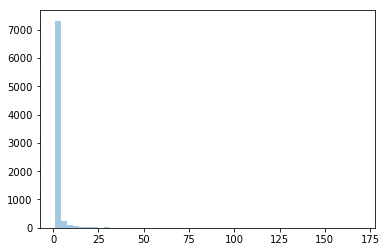

In [7]:
x = [len(dic_cluster[c]["details"]) for c in dic_cluster]
sns.distplot(x, kde=False)

#### Cluster types

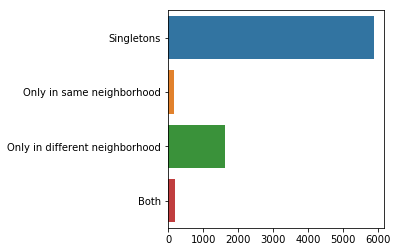

In [13]:
nb_singleton = len([c for c in dic_cluster if dic_cluster[c]["type"] == "singleton"]) 
nb_same_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"]=="only_in_same_neighborhood"]) 
nb_unique_neighborhood = len([c for c in dic_cluster if dic_cluster[c]["type"] == "only_in_different_neighborhood"]) 
nb_both = len([c for c in dic_cluster if dic_cluster[c]["type"] == "both"]) 
y = ["Singletons", "Only in same neighborhood", "Only in different neighborhood", "Both"]
x = [nb_singleton, nb_same_neighborhood, nb_unique_neighborhood, nb_both]
plot = sns.barplot(x,y)
plt.subplots_adjust(left=0.4)
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/clusters_types.pdf")

#### Neighborhood sizes 
Size of space with 10 proteins before and after NOX

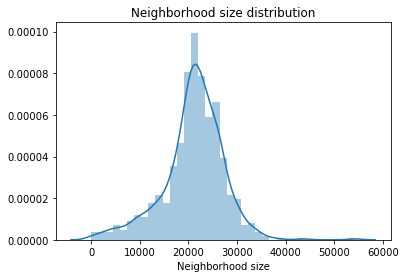

In [18]:
x = []
for e in data_uniprot:
    if len(e.neighborhood_ena_entry.features) != 0: 
        start = e.neighborhood_ena_entry.features[0].location.replace("complement(", '').split("..")[0]
        if "<" in start:
            start = start.replace("<",'')
        end = e.neighborhood_ena_entry.features[-1].location.replace(")", '').split("..")[1]
        if ">" in end:
            end = end.replace(">", '')
        neighborhood_size = int(end) - int(start)
        x.append(neighborhood_size)
plot = sns.distplot(x)   
plot.set(xlabel = "Neighborhood size", title = "Neighborhood size distribution")
plot.get_figure().savefig("/Users/chilpert/Results/NOX_visu_clean/Neighborhood/neighborhood_size_distribution.pdf")

### Add keywords and GO annotation

#### Write neighbors proteins accession id in file

In [19]:
o = open("/Users/chilpert/cache/NOX_neighbors10_protein_id.txt", "w")
for c in dic_cluster:
    for p in dic_cluster[c]["details"]:
        o.write(p.split("+")[2].split(".")[0] + "\n")
o.close()    

#### Download uniprot entry for neighbors
```console
mkdir -p/Users/chilpert/cache/uniprot_neighbors
cd /Users/chilpert/cache/uniprot_neighbors
bash /Users/chilpert/Dev/NOX/download_uniprot_entries_query.sh /Users/chilpert/cache/NOX_neighbors10_protein_id.txt
```

TO DO : Need to separate this in several volume to download quicly.

#### Parse GO and keywords term

In [20]:
uColl = uniprot.getUniprotCollection()
uColl.setCache("/Users/chilpert/cache/uniprot_neighbors")

Acknowledged 0 entries (/Users/chilpert)
Changing cache location to /Users/chilpert/cache/uniprot_neighbors
Reindexing /Users/chilpert/cache/uniprot_neighbors
Acknowledged 19235 entries (/Users/chilpert/cache/uniprot_neighbors)


#### Add GO, keywords and Interpro information to cluster dictionnary

In [21]:
for c in dic_cluster:
    for p in dic_cluster[c]["details"]: 
        p_id = p.split("+")[2].split(".")[0]
        try : 
            uniprot_entry=uColl.get(p_id, force_reading_cache = True)
        except:
            print(p, "not found")
            dic_cluster[c]["details"][p]["go"] = "uniprot not found"
            dic_cluster[c]["details"][p]["keywords"] = "uniprot not found"
            dic_cluster[c]["details"][p]["interpro"] = "uniprot not found"
            continue
        if not uniprot_entry.GO: 
            go = 'no uniprot go'
        else:    
            go = ";".join(sorted([go.term for go in uniprot_entry.GO]))
        if not uniprot_entry.KW:
            keywords = "no uniprot keywords"
        else:
            keywords = ";".join(sorted([kw.term for kw in uniprot_entry.KW if "proteome" not in kw.term]))
            if not keywords:
                keywords = "proteome"
        if not uniprot_entry.Interpro:
            interpro = "no interpro domains"
        else: 
            interpro = ";".join(sorted([i.id+":"+i.name for i in uniprot_entry.Interpro]))
        dic_cluster[c]["details"][p]["go"] = go
        dic_cluster[c]["details"][p]["keywords"] = keywords
        dic_cluster[c]["details"][p]["interpro"] = interpro

tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS455_Genome_element1+ASZ49468.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS459_Genome_element1+ASZ49471.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS449_Genome_element1+ASZ49462.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS462_Genome_element1+ASZ49474.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS447_Genome_element1+ASZ49460.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS463_Genome_element1+ASZ49475.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS445_Genome_element1+ASZ49458.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS450_Genome_element1+ASZ49463.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS451_Genome_element1+ASZ49464.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS444_Genome_element1+ASZ49457.1 not found
tr|A0A249VYJ9|A0A249VYJ9_VIBPH+CDS458_Genome_element1+ASZ49470.1 not found


#### Serialize cluster dictionnary

In [22]:
save(dic_cluster,"dic_cluster")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_dic_cluster_20190809-114952.pickle


### Define annotation for clusters (at different level) and identify clusters to curate manually. 
Clusters can be annotate at several levels : 
* product : if all proteins of cluster have same product, product annotation is set. 
* uniprot keywords : common keywords among all proteins of cluster is kept for annotation 
* go term : common go term among all proteins of cluster is kept for annotation
* interpro : common interpro domain/family among all proteins of cluster is kept for annotation

A cluster has to be curate manually if no annotation level can be set. 

#### Add clusters information to topology container

In [23]:
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins_cluster.tsv")

#### Assign taxid and protein list to clusters

In [24]:
for c in dic_cluster:
    prot = [e for e in data_uniprot if c in e.neighborhood_clusters.values()]
    prot_name = [e.prot for e in prot]
    taxids = [e.taxo.taxid for e in prot]
    dic_cluster[c]["taxids"] = taxids
    dic_cluster[c]["nox"] = prot_name

In [25]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
for c in dic_cluster:
    tree = ncbi.get_topology(dic_cluster[c]["taxids"])
    dic_cluster[c]["upper"] = next(tree.traverse())

#### Annotate clusters

In [26]:
def minimize_annotation(list_annotation):
    '''Conserve only common annotation'''
    list_annotation = [l.split(";") for l in list_annotation]
    for l in list_annotation:
        for word in ["proteome", "no uniprot go", "no uniprot keywords", "no interpro domains", "uniprot not found"]:
            if word in l:
                l.remove(word)
            
    list_annotation = [l for l in list_annotation if l]
    if not list_annotation:
        minim_annotation = "no information"
    elif len(list_annotation) == 1:
        minim_annotation = ";".join(list_annotation[0])
    else:
        minim_annotation = get_similar(list_annotation)
        if not minim_annotation:
            return None
        minim_annotation = ";".join(sorted(list(minim_annotation)))
    return minim_annotation

In [27]:
def get_similar(list_words):
    '''Keep similar words among given lists'''
    words_to_keep = set(list_words[0])
    for i in range(1,len(list_words)):
        words_to_keep = words_to_keep.intersection(set(list_words[i]))
        #print("W",words_to_keep)
        if not words_to_keep: 
            return words_to_keep
    return words_to_keep

In [28]:
kw_annotation_dic = {}
product_annotation_dic = {}
go_annotation_dic = {}
interpro_annotation_dic = {}
for c in dic_cluster : 
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    
    kw_annotation = minimize_annotation(keywords)
    
    go_annotation = minimize_annotation(go)
    
    interpro_annotation = minimize_annotation(interpro)
    
    if kw_annotation:
        kw_annotation_dic[c] = kw_annotation
        
    if go_annotation:
        go_annotation_dic[c] = go_annotation
    
    if interpro_annotation:
        interpro_annotation_dic[c] = interpro_annotation
    
    if "hypothetical protein" in product:
        product.remove("hypothetical protein")
    
    if len(set(product)) == 0:
        product_annotation_dic[c] = "hypothetical protein"
    elif len(set(product)) == 1:
        product_annotation_dic[c] = product[0]

#### Write valid annotated clusters and detailed information on clusters

In [29]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/valid_annotation_clusters.tsv" , "w")
o.write("#Cluster\tNumber of proteins\tNumber of neighborhoods\tUpper node\tProduct\tKeywords\tGO\tInterpro\n")
detail = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/detailed_annotation_clusters.txt", "w")
to_check = set()
for c in dic_cluster: 
    detail.write("#Cluster" + str(c) + "\n")
    for p in dic_cluster[c]["details"]:
        p_id = p.split("+")[2]
        product = dic_cluster[c]["details"][p]["product"] 
        kw = dic_cluster[c]["details"][p]["keywords"] 
        go = dic_cluster[c]["details"][p]["go"] 
        interpro = dic_cluster[c]["details"][p]["interpro"]
        detail.write(p_id + "\t" + product + "\t" + kw + "\t" + go + "\t" + interpro + "\n")
    if c in product_annotation_dic or c in kw_annotation_dic or c in go_annotation_dic or c in interpro_annotation_dic: 
        neighborhood_number = len([e for e in data_uniprot if c in e.neighborhood_clusters.values()])
        upper_node = dic_cluster[c]["upper"].name+":"+dic_cluster[c]["upper"].sci_name
        o.write(str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\t" + str(neighborhood_number) + "\t" + 
                upper_node + "\t" +
                product_annotation_dic.get(c,"-") + "\t" + kw_annotation_dic.get(c,"-") + "\t" +
               go_annotation_dic.get(c,"-") + "\t" + interpro_annotation_dic.get(c,"-") + "\n")
    else: 
        to_check.add(c)
o.close()   
detail.close()

In [30]:
o = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/to_check_clusters.txt", "w")
for c in to_check:
    o.write("#Cluster" + str(c) + "\t" + str(len(dic_cluster[c]["details"])) + "\n")
    product = [dic_cluster[c]["details"][p]["product"] for p in dic_cluster[c]["details"]]
    product = sorted(product, key=lambda e:product.count(e), reverse = True)
    keywords = [dic_cluster[c]["details"][p]["keywords"] for p in dic_cluster[c]["details"]]
    keywords = sorted(keywords, key=lambda e:keywords.count(e), reverse = True)
    go = [dic_cluster[c]["details"][p]["go"] for p in dic_cluster[c]["details"]]
    go = sorted(go, key=lambda e:go.count(e), reverse = True)
    interpro = [dic_cluster[c]["details"][p]["interpro"] for p in dic_cluster[c]["details"]]
    interpro = sorted(interpro, key=lambda e:interpro.count(e), reverse = True)
    for p in set(product):
        o.write("P\t" + p + "\t" + str(product.count(p)) + "\n")
    for k in set(keywords):
        o.write("KW\t" + k + "\t" + str(keywords.count(k)) + "\n")
    for g in set(go):
        o.write("GO\t" + g + "\t" + str(go.count(g)) + "\n")
    for i in set(interpro):
        o.write("I\t" + i + "\t" + str(interpro.count(i)) + "\n")
o.close()

No cluster to check manually.

### Regroup same annotations
Regroup clusters with same annotation at each level

In [31]:
same_product = {}
same_keywords = {}
same_go = {}
same_interpro = {}
same_all = {}
all_annotation_dic = {}

def add_to_dic(dic,term,cluster):
    if term not in dic:
        dic[term] = []
    dic[term].append(cluster)    

f = open("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/valid_annotation_clusters.tsv", "r")
f.readline()
for l in f: 
    l_split = l.rstrip().split("\t")
    cluster = l_split[0] 
    product = l_split[4]
    kw = l_split[5]
    go = l_split[6]
    interpro = l_split[7]
    all = product + "+" + kw + "+" + go + "+" + interpro
    
    all_annotation_dic[int(cluster)] = all
    
    add_to_dic(same_product, product, cluster)
    add_to_dic(same_keywords, kw, cluster)
    add_to_dic(same_go, go, cluster)
    add_to_dic(same_interpro, interpro, cluster)
    add_to_dic(same_all, all, cluster)
    
f.close()
same_product = OrderedDict(sorted(same_product.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_keywords = OrderedDict(sorted(same_keywords.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_go = OrderedDict(sorted(same_go.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_interpro = OrderedDict(sorted(same_interpro.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))
same_all = OrderedDict(sorted(same_all.items(),
                                     key=lambda kv: len(kv[1]),
                                     reverse=True))

#### Write outputs

In [32]:
for e in data_uniprot:
    e.clusters_list = list(e.neighborhood_clusters.values())
    e.clusters_annotation = {}
    e.clusters_annotation["product"]=[product_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["keywords"]=[kw_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["go"]=[go_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["interpro"]=[interpro_annotation_dic.get(c,"-") for c in e.clusters_list]
    e.clusters_annotation["all"]=[all_annotation_dic.get(c,"-") for c in e.clusters_list]

In [70]:
def write_same(file, dic, annotation_type):
    o = open(file,"w")
    o.write("#" + annotation_type + "\t" + "Number of clusters\tNumber of proteins\tNumber of neighborhoods\tUpper node\n")
    count = 0
    print("==",annotation_type)
    for w in dic:
        count += 1
        if count%100 == 0: 
            print(count,"/",len(dic))
        nb_proteins = sum([len(dic_cluster[int(c)]["details"]) for c in dic[w]])
        neighborhoods = set()
        for c in dic[w]:
            neighborhoods.update(dic_cluster[int(c)]["nox"])
        neighborhoods_taxids = [e.taxo.taxid for e in data_uniprot if e.prot in neighborhoods]    
        tree = ncbi.get_topology(neighborhoods_taxids)
        upper_node = next(tree.traverse())
        nb_neighborhoods = len(neighborhoods)
        nb_clusters = len(dic[w])
        o.write(w + "\t" + str(nb_clusters) + "\t" + str(nb_proteins) + "\t" + str(nb_neighborhoods) + "\t" + upper_node.name+":"+upper_node.sci_name + "\n")
    o.close()

#write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_product.tsv", same_product, "product")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_keywords.tsv", same_keywords, "Keywords")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_go.tsv", same_go, "GO")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_interpro.tsv", same_interpro, "Interpro")
write_same("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/clusters_annotations_same_all.tsv", same_all, "All annotation")

== Keywords
100 / 945
200 / 945
300 / 945
400 / 945
500 / 945
600 / 945
700 / 945
800 / 945
900 / 945
== GO
100 / 1827
200 / 1827
300 / 1827
400 / 1827
500 / 1827
600 / 1827
700 / 1827
800 / 1827
900 / 1827
1000 / 1827
1100 / 1827
1200 / 1827
1300 / 1827
1400 / 1827
1500 / 1827
1600 / 1827
1700 / 1827
1800 / 1827
== Interpro
100 / 4092
200 / 4092
300 / 4092
400 / 4092
500 / 4092
600 / 4092
700 / 4092
800 / 4092
900 / 4092
1000 / 4092
1100 / 4092
1200 / 4092
1300 / 4092
1400 / 4092
1500 / 4092
1600 / 4092
1700 / 4092
1800 / 4092
1900 / 4092
2000 / 4092
2100 / 4092
2200 / 4092
2300 / 4092
2400 / 4092
2500 / 4092
2600 / 4092
2700 / 4092
2800 / 4092
2900 / 4092
3000 / 4092
3100 / 4092
3200 / 4092
3300 / 4092
3400 / 4092
3500 / 4092
3600 / 4092
3700 / 4092
3800 / 4092
3900 / 4092
4000 / 4092
== All annotation
100 / 5804
200 / 5804
300 / 5804
400 / 5804
500 / 5804
600 / 5804
700 / 5804
800 / 5804
900 / 5804
1000 / 5804
1100 / 5804
1200 / 5804
1300 / 5804
1400 / 5804
1500 / 5804
1600 / 5804
1

### Neighborhoods representation

In [71]:
data_uniprot.add_neighborhood_clusters("/Volumes/arwen/mobi/group/NOX_clean/results/Neighborhood/neighbors_proteins_cluster.tsv")

In [78]:
def add_to_annotation_list(annotation_list,clusters,annotation_dic):
    for c in clusters:
        if c in annotation_dic and c != "hypothetical protein" and c != "no information":
            annotation_list.append(annotation_dic[c])
        else:
            annotation_list.append(c)
    return annotation_list        

dic_prot_clusters ={}
for e in data_uniprot:
    product = []
    keywords = []
    go = []
    all = []
    clusters = []
    if hasattr(e, "neighborhood_clusters"):
        clusters = [e.neighborhood_clusters[p] for p in e.neighborhood_clusters]
        product = add_to_annotation_list(product, clusters, product_annotation_dic)
        keywords = add_to_annotation_list(keywords, clusters, kw_annotation_dic)
        go = add_to_annotation_list(go, clusters, go_annotation_dic)
        all = add_to_annotation_list(all, clusters, all_annotation_dic)
    dic_prot_clusters[e.prot] = {'clusters' : clusters, 'product' : product, 'keywords' : keywords,
                           'go' : go, 'all' : all}

In [79]:
def create_distance_matrix(annotation_type, data, dic_prot_clusters):
    distance_matrix = {}
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            prot1 = data[i].prot
            prot2 = data[j].prot
            if prot1 not in distance_matrix:
                distance_matrix[prot1] = {}
            distance_matrix[prot1][prot2] = jaccard_distance(dic_prot_clusters[prot1][annotation_type], dic_prot_clusters[prot2][annotation_type]) 
    return distance_matrix

In [80]:
def jaccard_distance(listA, listB):
    inter = set(listA).intersection(set(listB))
    union = set(listA).union(set(listB))
    dist = len(inter) / len(union)
    return dist

In [81]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
def get_tax_level(taxid, level):
    lineage = ncbi.get_lineage(taxid)
    ranks = ncbi.get_rank(lineage)
    level_name = "no " + level
    if level in ranks.values():
        level_id = [id for id in ranks if ranks[id] == level]
        level_name = ncbi.get_taxid_translator(level_id)[level_id[0]]
    return level_name   

In [89]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

cm = plt.get_cmap('Purples') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

def get_graph(neighborhood_matrix, data, min_jaccard_dist):
    g=Graph()
    g.add_vertices(len(data))
    g.vs["name"] = [e.prot for e in data]
    #g.vs["label"] = [e.prot.split("|")[1] for e in data[:100]]
    for p1 in neighborhood_matrix:
        for p2 in neighborhood_matrix[p1]:
            if neighborhood_matrix[p1][p2] >= min_jaccard_dist :
                g.add_edges([(p1,p2)])
    for v in g.vs: 
        v["size"] = 3
        v["color"] = "purple"
        v["taxid"] = data_uniprot.entries[v["name"]].taxo.taxid
    for e in g.es: 
        source = [v for v in g.vs if v.index == e.source][0]
        target = [v for v in g.vs if v.index == e.target][0]
        e["weight"] = neighborhood_matrix[source["name"]][target["name"]]
    
    sorted_edges=sorted(g.es, key=lambda edge: edge["weight"])
    for e in sorted_edges:
        e["color"] = scalarMap.to_rgba(e["weight"])
    return g     

In [76]:
matrix_cluster = create_distance_matrix("clusters", data_uniprot, dic_prot_clusters)
#test_product = create_distance_matrix("product", data_uniprot, dic_prot_clusters)
#test_keywords = create_distance_matrix("keywords", data_uniprot, dic_prot_clusters)
#test_go = create_distance_matrix("go", data_uniprot, dic_prot_clusters)

In [104]:
i = 0.1
graphs_save = {}
while i <= 1:
    i_str = str(round(i,1))
    print(i_str)
    g = get_graph(matrix_cluster, data_uniprot, i)
    graphs_save[i_str] = g
    plot(g, target = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs/cluster_graphs/all_dist" + i_str + ".pdf")
    
    i += 0.1
#g_prod = get_graph(test_product, data_uniprot, 0.5)
#plot(g_prod, target = "/Users/chilpert/Results/NOX_visu_test/test_all_product_05.pdf")
#g_kw = get_graph(test_keywords, data_uniprot, 0.5)
#plot(g_kw, target = "/Users/chilpert/Results/NOX_visu_test/test_all_keywords_08.pdf")
#g_go = get_graph(test_go, data_uniprot, 0.5)
#plot(g_go, target = "/Users/chilpert/Results/NOX_visu_test/test_all_go_05.pdf")

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [114]:
for d in graphs_save: 
    g = graphs_save[d]
    connected_comp = g.clusters()
    nb_cc=0
    for cc in connected_comp.subgraphs():
        if len(cc.vs) > 1:
            for v in cc.vs: 
                v["label"] = v["name"].split("|")[1]
            nb_cc += 1
            res_dir = "/Users/chilpert/Results/NOX_visu_clean/Neighborhood_graphs/cluster_graphs/cc_" + d
            if not os.path.exists(res_dir):
                os.system("mkdir "+res_dir) 
            plot(cc,target = res_dir + "/cc_"+str(nb_cc)+".pdf", vertex_label_size=12, margin=100,
                 vertex_label_dist=2, vertex_size=5)
            for v in cc.vs:
                v["label"] = data_uniprot.entries[v["name"]].taxo.taxname    
                v["taxid"] = data_uniprot.entries[v["name"]].taxo.taxid
            plot(cc,target = res_dir + "/cc" +str(nb_cc)+"_taxo.pdf", vertex_label_size=12, margin=150,
                 vertex_label_dist=2, vertex_size=5)    